In [6]:
# Basic operations
import numpy as np
import pandas as pd

# Visualizations
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
# Import csv files
df = pd.read_csv("UMW_FR_reduced.csv", sep=",")
imdb = pd.read_csv("IMDB_movies_data_clean.csv", sep=",")
tags = pd.read_csv("tags_clean.csv", sep=",")

In [52]:
# Aggregate by movies
cols = ['original_title', 'royalties_paid_eur']
df_revenue = df[cols].groupby('original_title')['royalties_paid_eur'].sum()
df_count = df[cols].groupby('original_title')['royalties_paid_eur'].count()
df_movies = pd.DataFrame({'revenue':df_revenue, 'count':df_count})

In [53]:
#Get the map between mama ids and original titles
cols = ['mama_movie_id', 'original_title']
id_to_title = df[cols].drop_duplicates().set_index('original_title')
id_to_title = id_to_title.dropna()
id_to_title['mama_movie_id'] = id_to_title['mama_movie_id'].astype(int)

In [54]:
#Join all the tables together
df_movies = df_movies.join(id_to_title)
df_movies = df_movies.merge(tags, left_on='mama_movie_id', right_on='id')

In [98]:
#Median revenue for each tag
data = df_movies.iloc[:, 4:].apply(lambda x:np.median(df_movies['revenue'][x>0]))
data_count = df_movies.iloc[:, 4:].apply(lambda x:len(x[x>0]))
data = pd.DataFrame({'revenue':data, 'count':data_count})
data = data.sort_values('revenue',ascending=False)
data = data.dropna()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

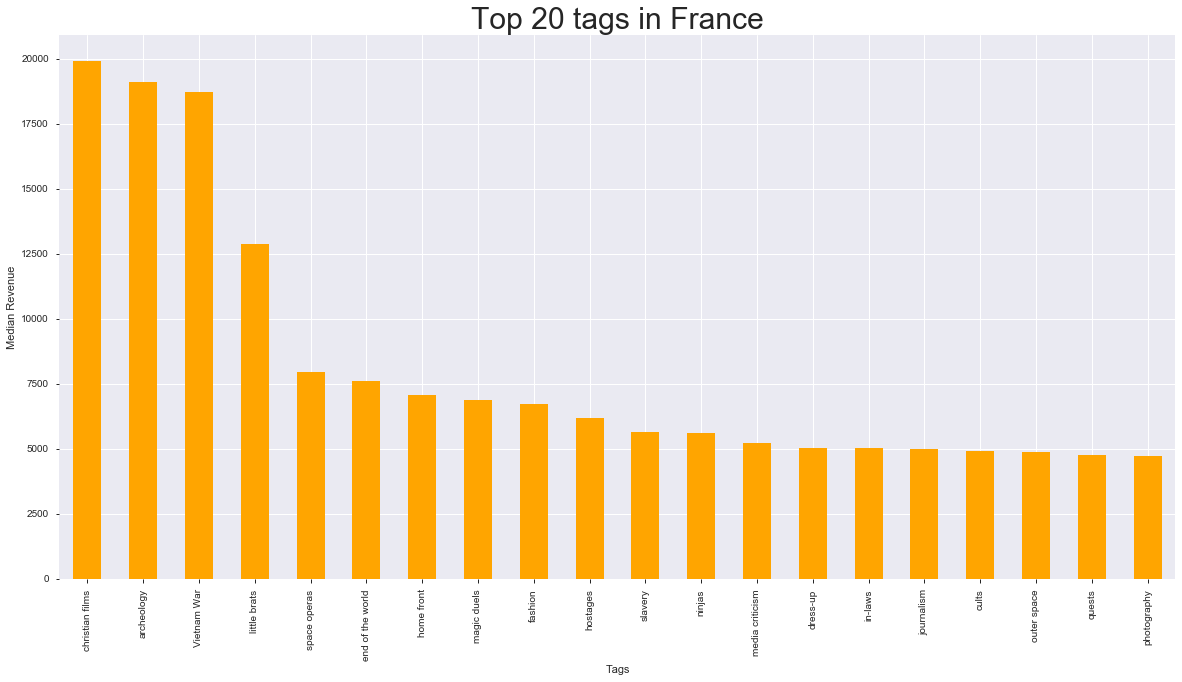

In [111]:
#Top 20 tags
data['revenue'][:20].plot.bar(color = 'orange', figsize = (20, 10))
plt.title('Top 20 tags in France', fontsize = 30, fontweight = 20)
plt.xlabel('Tags')
plt.ylabel('Median Revenue')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

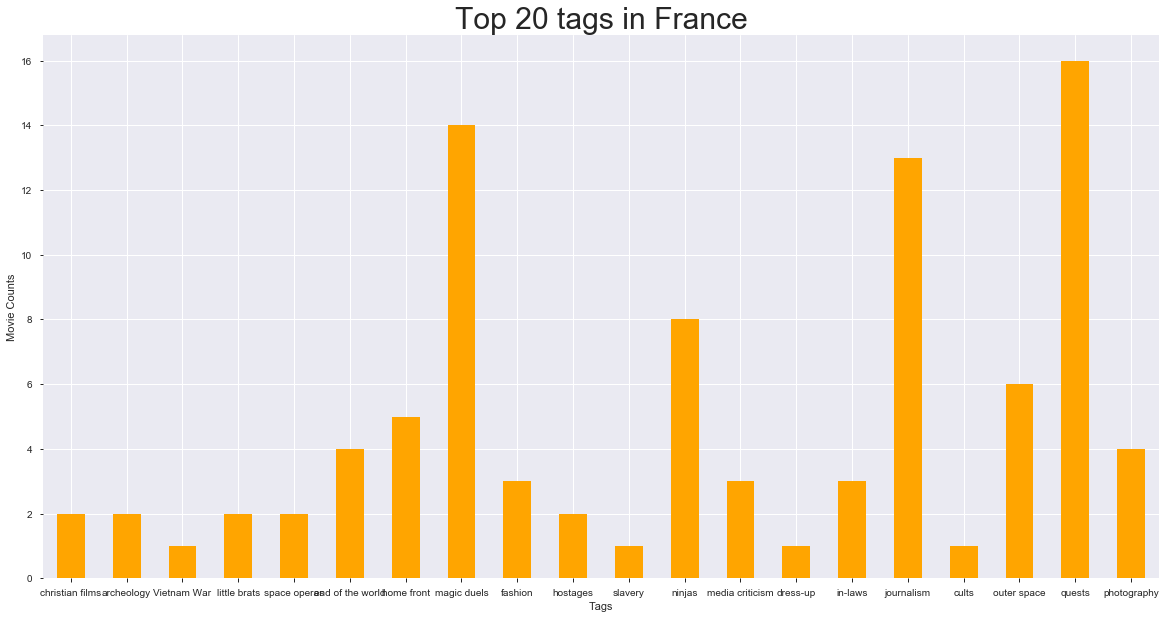

In [107]:
# Corresponding movie counts (if a tag appears only once then its median revenue is probably not reliable)
data['count'][:20].plot.bar(color = 'orange', figsize = (20, 10))
plt.title('Top 20 tags in France', fontsize = 30, fontweight = 20)
plt.xlabel('Tags')
plt.ylabel('Movie Counts')
plt.xticks(rotation=0)